In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt
from math import pi, sqrt
import pywt
from matplotlib import cm
from numpy import exp
from skimage import filters

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

diabetic-retinopathy-224x224-2019-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref= zipfile.ZipFile("/content/diabetic-retinopathy-224x224-2019-data.zip")
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
def preprocess_image(image_path, target_height, target_width):
    image = Image.open(image_path)
    image = image.resize((target_width, target_height))
    image = np.array(image)
    return image

In [6]:
folder_path = '/content/colored_images'

In [7]:
for folder in os.listdir(folder_path):
  print(folder)

Moderate
Mild
Severe
Proliferate_DR
No_DR


In [8]:
labels = pd.read_csv('/content/train.csv')

In [9]:
labels

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [10]:
class1={}
class1[0]=[]
class1[1]=[]
class1[2]=[]
class1[3]=[]
class1[4]=[]

In [11]:
X=[]
y=[]
count=0
for folder in os.listdir(folder_path):
    path = folder_path+"/"+folder
    for image_path in os.listdir(path):
      img_path=path+"/"+image_path
      image = preprocess_image(img_path,224,224)
      X.append(image)
      label=labels[labels['id_code']==image_path[:-4]]['diagnosis'].values
      y.append(label)
      t_image = plt.imread(img_path)
      # print(class1[label[0]])
      if len(class1[label[0]])<5:
        class1[label[0]].append(t_image)
      count+=1

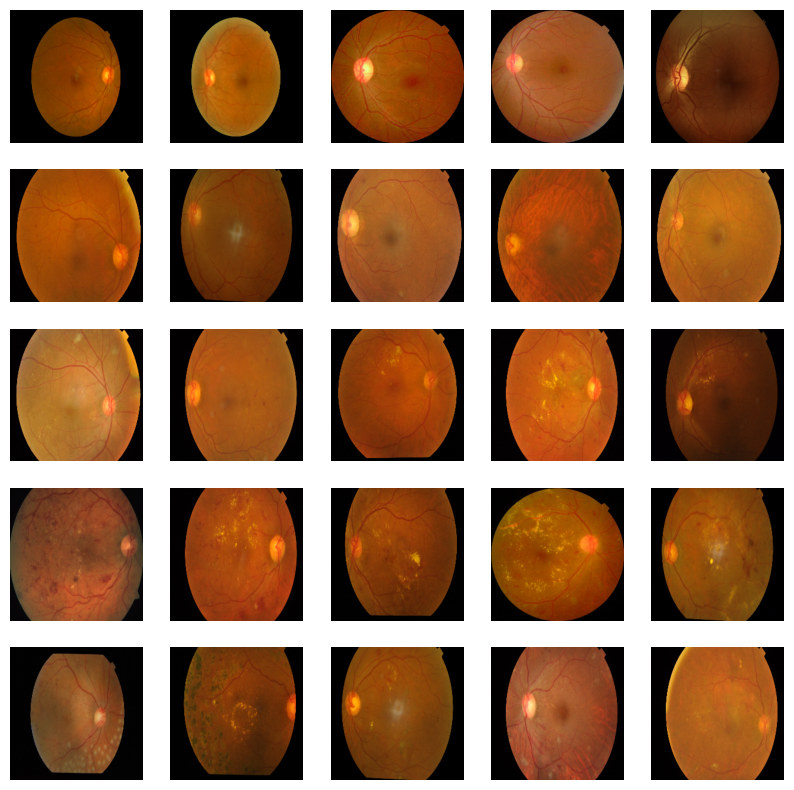

In [12]:
plt.figure(figsize=(10,10))
for i in range(5):
  for j in range(len(class1[i])):
    plt.subplot(5,5,5*i+j+1)
    plt.imshow(class1[i][j])
    plt.axis('off')

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
X.shape

(3662, 224, 224, 3)

In [15]:
y.shape

(3662, 1)

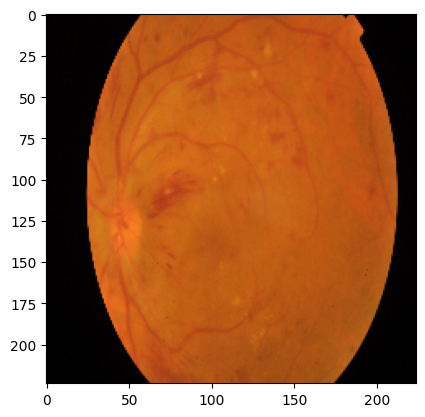

In [16]:
plt.imshow(X[78],cmap='gray')

In [17]:
immatrix=[]
for img in X:
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  equ = cv2.equalizeHist(img_gray)
  immatrix.append(np.array(equ))

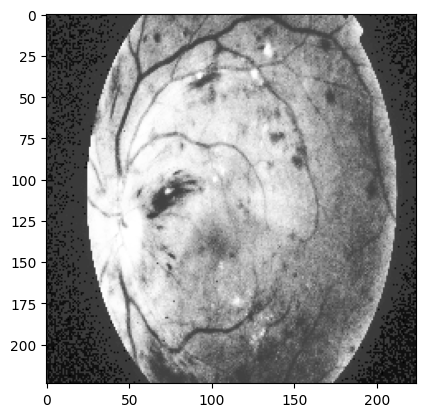

In [18]:
plt.imshow(immatrix[78],cmap='gray')

In [19]:
np.shape(np.array(equ).flatten())

(50176,)

In [20]:
imm_dwt = []
for equ in immatrix:
    # equ = equ.reshape((224,224))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2))

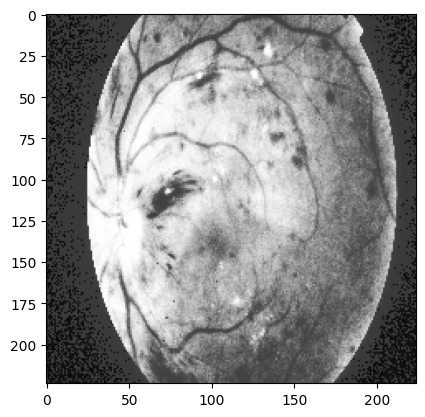

In [21]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[78],cmap='gray')
plt.show()

In [22]:
pixel_features = []
for i in imm_dwt:
  pixel_feat = np.reshape(i,(224 * 224))
  pixel_features.append(pixel_feat)

In [23]:
pixel_feat1 = np.reshape(imm_dwt[0],(224 * 224))
pixel_feat1

array([37., 37., 37., ..., 37., 37., 37.])

In [24]:
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv2.filter2D(imm_dwt[0], -1, kernelx)
img_prewitty = cv2.filter2D(imm_dwt[0], -1, kernely)

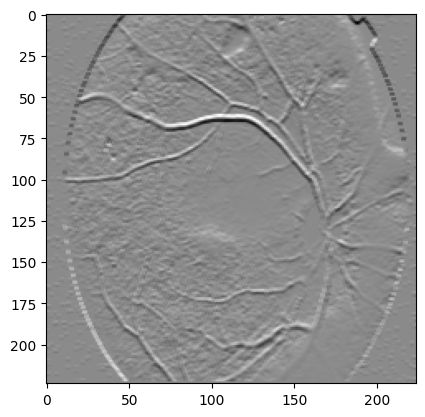

In [25]:
plt.imshow(img_prewittx, cmap='gray')

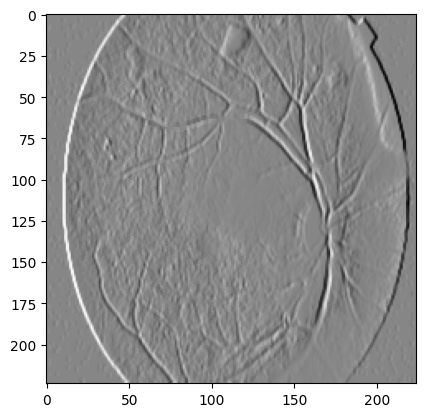

In [26]:
plt.imshow(img_prewitty, cmap='gray')

In [27]:
# Sobel Kernel
ed_sobel = filters.sobel(imm_dwt[0])

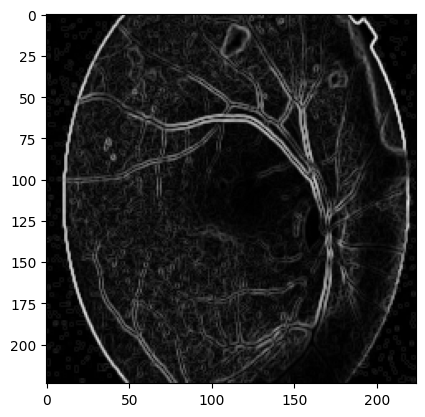

In [28]:
plt.imshow(ed_sobel, cmap='gray')

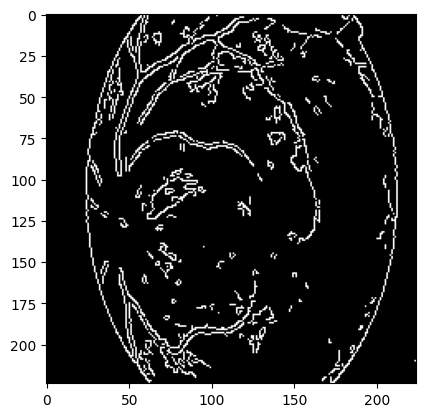

In [29]:
temp = imm_dwt[78].astype(np.uint8)
img_canny = cv2.Canny(temp,200,300)
plt.imshow(img_canny, cmap='gray')

In [30]:
canny_features = []
for i in imm_dwt:
  temp = i.astype(np.uint8)
  img_canny = cv2.Canny(temp,200,300)
  t = np.reshape(img_canny,(224 * 224))
  canny_features.append(t)

In [31]:
np.array(canny_features).shape

(3662, 50176)

In [32]:
np.array(pixel_features).shape

(3662, 50176)

In [33]:
features = np.hstack((pixel_features, canny_features))

In [34]:
features.shape

(3662, 100352)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

**Combining the pixel features and canny edge features**


1.   Training various ML models based on these features
2.   Computing the accuracy score for each of these models



In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

<ipython-input-37-d7e06eece622>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [52]:
RF_accuracy = accuracy_score(y_test,y_pred)

In [59]:
print("Accuracy:", RF_accuracy)

Accuracy: 0.8132118479153756


In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
LR_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", LR_accuracy)

Accuracy: 0.7353342428376535


In [41]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [71]:
DT_accuracy = accuracy_score(y_test,y_pred)

In [73]:
print("Accuracy:", DT_accuracy)

Accuracy: 0.786861330531682


In [43]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [63]:
KNN_accuracy = accuracy_score(y_test,y_pred)

In [65]:
print("Accuracy:", KNN_accuracy)

Accuracy: 0.7641351099383933


In [46]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
SVC_rbf_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_rbf_accuracy)

Accuracy: 0.7339699863574352


In [48]:
from sklearn.svm import SVC
model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
SVC_poly_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_poly_accuracy)

Accuracy: 0.7517053206002728


**Maximum accuracy of 81.32% is achieved in Random Forest algorithm**

**Only considering the sobel features in the case of edge detection through sobel filter and not considering the pixel features so as to try out various combinations**

In [30]:
sobel_features = []
for i in imm_dwt:
  ed_sobel = filters.sobel(i)
  t = np.reshape(ed_sobel,(224 * 224))
  sobel_features.append(t)

In [31]:
np.array(sobel_features).shape

(3662, 50176)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(sobel_features, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

<ipython-input-33-d7e06eece622>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [36]:
RF_accuracy = accuracy_score(y_test,y_pred)

In [37]:
print("Accuracy:", RF_accuracy)

Accuracy: 0.7189631650750341


In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
LR_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", LR_accuracy)

Accuracy: 0.7216916780354706


In [44]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [45]:
DT_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", DT_accuracy)

Accuracy: 0.6289222373806276


In [46]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [47]:
KNN_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", KNN_accuracy)

Accuracy: 0.7080491132332879


In [48]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
SVC_rbf_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_rbf_accuracy)

Accuracy: 0.73806275579809


In [50]:
from sklearn.svm import SVC
model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
SVC_poly_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_poly_accuracy)

Accuracy: 0.7394270122783083


**Adding the prewitt features of X and Y axis and not considering the pixel features**

In [52]:
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

In [53]:
prewitt_features = []
for i in imm_dwt:
  img_prewittx = cv2.filter2D(i, -1, kernelx)
  img_prewitty = cv2.filter2D(i, -1, kernely)
  temp = np.array(img_prewittx)+np.array(img_prewitty)
  t = np.reshape(temp,(224 * 224))
  prewitt_features.append(t)

In [55]:
np.array(prewitt_features).shape

(3662, 50176)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(prewitt_features, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
RF_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", RF_accuracy)

<ipython-input-60-8f42c8904b89>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Accuracy: 0.7203274215552524


In [61]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
LR_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", LR_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7175989085948158


In [62]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
DT_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", DT_accuracy)

Accuracy: 0.6343792633015006


In [63]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
KNN_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", KNN_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.6712141882673943


In [64]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
SVC_rbf_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_rbf_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7339699863574352


In [65]:
from sklearn.svm import SVC
model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
SVC_poly_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", SVC_poly_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6534788540245566
